# 09-12-2020 Model improvements
- try a different model OK
- try branching two models (one for maj/min, one for the letter) OK
- do something for really under represented classes (discard? data augmentation?) OK
- try using the deep chroma processor (madmom) instead of chromagrams
- plot confusion matrix and analyse fuckups - data augmentation?

In [11]:
# imports
import pandas as pd
import numpy as np
from numpy import load
from numpy import asarray
from numpy import save
from numpy import mean
from numpy import std

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
sns.set(style='ticks')

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

C:\Users\derob\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\derob\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\derob\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\derob\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

**load and explore data**

In [14]:
path_data = 'data_processed/'
path_pickles = 'pickles/'
path_images = 'images/'

In [15]:
data = pd.read_csv(path_data + "chords_comp_clean.csv", index_col=0)

In [16]:
data.head()

,id,track_name,time,duration,chord_instructed,chord_played,to_keep
0,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1,True
1,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1,True
2,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1,True
3,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1",True
4,00_BN1-129-Eb_comp_5,00_BN1-129-Eb_comp,18.604651,3.719749,D#:maj,D#:maj7/1,True


In [17]:
data.chord_instructed.value_counts()

F:maj       122
C:maj        98
G:maj        94
D#:maj       90
C#:maj       79
G#:maj       75
A#:maj       74
F#:maj       73
E:maj        70
D:maj        69
A:maj        67
B:maj        62
E:min        51
G:min        47
C#:min       42
A#:min       38
G#:min       37
B:min        33
A:min        33
D:min        30
F:min        28
D#:7         25
C:min        20
F#:min       19
D#:min       18
F#:7         18
C:7          17
A:7          16
G:hdim7      14
A#:hdim7     14
F:7          12
C#:7         11
G#:hdim7      8
A#:7          8
F:hdim7       8
C:hdim7       7
E:7           6
G#:7          6
C#:hdim7      6
E:hdim7       6
D:7           4
A:hdim7       4
Name: chord_instructed, dtype: int64

**Remove really under representated classes (hdim and 7)**

In [18]:
# discard all seventh
for i, row in data.iterrows():
    if '7' in str(row.chord_instructed):
        data.loc[i, 'to_keep'] = False

In [19]:
data.head()

,id,track_name,time,duration,chord_instructed,chord_played,to_keep
0,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1,True
1,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1,True
2,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1,True
3,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1",True
4,00_BN1-129-Eb_comp_5,00_BN1-129-Eb_comp,18.604651,3.719749,D#:maj,D#:maj7/1,True


In [20]:
data_clean = data[data.to_keep == True]
data_clean.chord_instructed.value_counts()

F:maj     122
C:maj      98
G:maj      94
D#:maj     90
C#:maj     79
G#:maj     75
A#:maj     74
F#:maj     73
E:maj      70
D:maj      69
A:maj      67
B:maj      62
E:min      51
G:min      47
C#:min     42
A#:min     38
G#:min     37
B:min      33
A:min      33
D:min      30
F:min      28
C:min      20
F#:min     19
D#:min     18
Name: chord_instructed, dtype: int64

**Prep data for modeling**

In [21]:
# create labels column and encode
le = LabelEncoder()
data_clean['labels'] = le.fit_transform(data_clean['chord_instructed'])

C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
len(data_clean['labels'].unique())

24

In [61]:
# save label encoder
import pickle
filename = 'labelencoder_24classes.sav'
pickle.dump(le, open(path_pickles + filename, 'wb'))

In [64]:
# convert images
photos = list()
for name in data_clean.id.values:
    # load image
    photo = load_img(path_images + name + '.png', color_mode = "grayscale", target_size=(64,64))
     # convert to np array
    photo = img_to_array(photo)
    #store
    photos.append(photo)
labels = list(data_clean['labels'].values)

In [65]:
# convert photos to np arrays
photos = asarray(photos)
photos.shape

(1369, 64, 64, 1)

In [66]:
# convert labels to np arrays
labels = asarray(labels)
labels.shape

(1369,)

In [67]:
# save arrays
save(path_data + 'photos_24classes.npy', photos)
save(path_data + 'labels_24classes.npy', labels)

# Try modeling with best model I have so far
Changes I've made:\
- batch size when training model on all params: 24 (was 32)
- epoch when training model on all params: 50 (was 20)
better performance, mean 82% (compared to 79 previously with the 7 and hdim chords)

In [97]:
# validation split from 10% to 15%
def load_dataset():
    # load arrays
    photos = load(path_data + 'photos_24classes.npy')
    labels = load(path_data + 'labels_24classes.npy')
    
    # split between train/test and reshape
    X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size=0.15, shuffle=False)
    y_train = np.reshape(y_train, (X_train.shape[0],))
    y_test = np.reshape(y_test, (X_test.shape[0],))
    
    # hot encode target variables
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, X_test, y_train, y_test

# no change
def prep_pixels(train, test):
    # convert from integers to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    # return normalized images
    return train_norm, test_norm

# define model  with 20 neurons at last layer
def define_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform', input_shape=(64, 64, 1))) #conv layer
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))              
    model.add(layers.Flatten()) # 16384 vector
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform')) # 1 hidden layer
    model.add(layers.Dense(24, activation='softmax')) # output, size 42 = nuber of classes
    # compile model
    opt = optimizers.SGD(lr=0.01, momentum=0.9) # gradient descent with momentum optimizer
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 15 epochs to evaluate
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list() # initializing to keep track
    # prep cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows to train/test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit the model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0) # returns loss value and eval metric, we're only interested in that second one
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# no change
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

# no change
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
# no change
def run_test_harness():
    # load dataset
    X_train, X_test, y_train, y_test = load_dataset()
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, X_test)
    # evaluate model
    scores, histories = evaluate_model(X_train, y_train)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> 84.120
> 84.979
> 83.691
> 76.724
> 81.466


C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


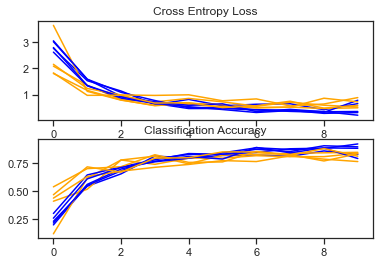

Accuracy: mean=82.196 std=2.972, n=5


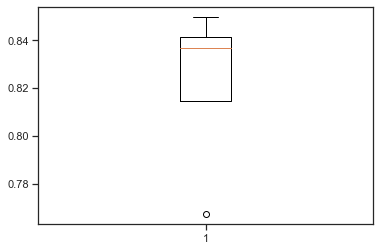

In [69]:
run_test_harness()

In [99]:
# fit model on whole data available - 20 epoch
# load dataset
X_train, X_test, y_train, y_test = load_dataset()
# prepare pixel data
X_train, X_test = prep_pixels(X_train, X_test)
model = define_model()
model.fit(X_train, y_train, epochs=50, batch_size=24)

Epoch 1/50
49/49 [==============================] - 4s 85ms/step - loss: 2.7412 - accuracy: 0.2709
Epoch 2/50
49/49 [==============================] - 4s 82ms/step - loss: 1.2216 - accuracy: 0.6518
Epoch 3/50
49/49 [==============================] - 4s 79ms/step - loss: 0.8059 - accuracy: 0.7481
Epoch 4/50
49/49 [==============================] - 4s 85ms/step - loss: 0.5732 - accuracy: 0.8134
Epoch 5/50
49/49 [==============================] - 4s 91ms/step - loss: 0.4890 - accuracy: 0.8340
Epoch 6/50
49/49 [==============================] - 4s 91ms/step - loss: 0.3965 - accuracy: 0.8573
Epoch 7/50
49/49 [==============================] - 5s 93ms/step - loss: 0.3773 - accuracy: 0.8796
Epoch 8/50
49/49 [==============================] - 5s 96ms/step - loss: 0.2661 - accuracy: 0.9106
Epoch 9/50
49/49 [==============================] - 5s 102ms/step - loss: 0.2693 - accuracy: 0.9106
Epoch 10/50
49/49 [==============================] - 5s 99ms/step - loss: 0.2577 - accuracy: 0.9157
Epoch 11

In [100]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 73.301


**30 epochs are enough**

In [111]:
# save mode5
model.save(path_pickles + 'final_model_24classes.h5')

# Try a model architecture inspired from Korzeniowski paper
Gave me something similar - didn't learn anything on one fold. keeping the model above

In [74]:
# define model  - new
def define_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform', input_shape=(64, 64, 1))) #conv layer
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))              
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))              
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(128, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform'))            
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform')) # 1 hidden layer
    model.add(layers.Dense(24, activation='softmax')) # output, size 42 = nuber of classes
    # compile model
    opt = optimizers.SGD(lr=0.01, momentum=0.9) # gradient descent with momentum optimizer
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
model = define_model()
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)      

> 84.979
> 83.691
> 87.124
> 11.207
> 85.776


C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


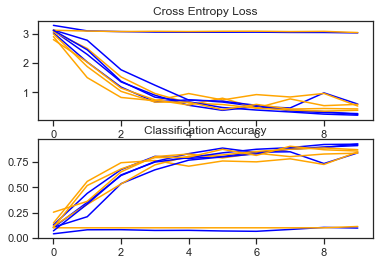

Accuracy: mean=70.555 std=29.695, n=5


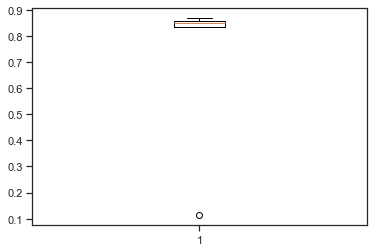

In [76]:
run_test_harness()

# Try a model with two branches
Not amazing results, keeping baseline model here.\
https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178

**split labels into letter and maj/min**

In [123]:
data_clean_split = data_clean
data_clean_split = data_clean_split.drop('labels', axis=1)
data_clean_split.head()

,id,track_name,time,duration,chord_instructed,chord_played,to_keep
0,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1,True
1,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1,True
2,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1,True
3,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1",True
4,00_BN1-129-Eb_comp_5,00_BN1-129-Eb_comp,18.604651,3.719749,D#:maj,D#:maj7/1,True


In [147]:
data_clean_split['label_1'] = data_clean_split['chord_instructed'].apply(lambda x: str(x)[:-4])
data_clean_split['label_2'] = data_clean_split['chord_instructed'].apply(lambda x: str(x)[-3:])

In [148]:
data_clean_split.head()

,id,track_name,time,duration,chord_instructed,chord_played,to_keep,label_1,label_2
0,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1,True,G#,maj
1,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1,True,D#,maj
2,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1,True,A#,maj
3,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1",True,G#,maj
4,00_BN1-129-Eb_comp_5,00_BN1-129-Eb_comp,18.604651,3.719749,D#:maj,D#:maj7/1,True,D#,maj


**prep the data**

In [149]:
# create labels column and encode
le1 = LabelEncoder()
le2 = LabelEncoder()
data_clean_split['label_1_encoded'] = le1.fit_transform(data_clean_split['label_1'])
data_clean_split['label_2_encoded'] = le2.fit_transform(data_clean_split['label_2'])

In [175]:
print(len(data_clean_split['label_1_encoded'].unique()))
print(len(data_clean_split['label_2_encoded'].unique()))

12
2


In [151]:
# save label encoder
filename1 = 'labelencoder_24classes_1.sav'
filename2 = 'labelencoder_24classes_2.sav'
pickle.dump(le, open(path_pickles + filename1, 'wb'))
pickle.dump(le, open(path_pickles + filename2, 'wb'))

In [154]:
# convert images
photos = list()
for name in data_clean_split.id.values:
    # load image
    photo = load_img(path_images + name + '.png', color_mode = "grayscale", target_size=(64,64))
     # convert to np array
    photo = img_to_array(photo)
    #store
    photos.append(photo)
labels_1 = list(data_clean_split['label_1_encoded'].values)
labels_2 = list(data_clean_split['label_2_encoded'].values)

In [155]:
# convert photos to np arrays
photos = asarray(photos)
photos.shape

(1369, 64, 64, 1)

In [156]:
# convert labels to np arrays
labels_1 = asarray(labels_1)
labels_2 = asarray(labels_2)
print(labels_1.shape)
print(labels_2.shape)

(1369,)
(1369,)


In [158]:
# save arrays
save(path_data + 'photos_24classes.npy', photos)
save(path_data + 'labels_24classes_1.npy', labels_1)
save(path_data + 'labels_24classes_2.npy', labels_2)

**load_data()**\
**prep_pixels()**

In [45]:
# functions
def load_dataset():
    # load arrays
    photos = load(path_data + 'photos_24classes.npy')
    labels_1 = load(path_data + 'labels_24classes_1.npy')
    labels_2 = load(path_data + 'labels_24classes_2.npy')
    
    # split between train/test and reshape
    X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(photos, labels_1, labels_2, test_size=0.15, shuffle=False)
    y1_train = np.reshape(y1_train, (X_train.shape[0],))
    y1_test = np.reshape(y1_test, (X_test.shape[0],))
    y2_train = np.reshape(y2_train, (X_train.shape[0],))
    y2_test = np.reshape(y2_test, (X_test.shape[0],))
    
    # hot encode target variables
    y1_train = to_categorical(y1_train)
    y2_train = to_categorical(y2_train)
    y1_test = to_categorical(y1_test)
    y2_test = to_categorical(y2_test)
    return X_train, X_test, y1_train, y1_test, y2_train, y2_test

def prep_pixels(train, test):
    # convert from integers to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    # return normalized images
    return train_norm, test_norm

In [46]:
# load dataset
X_train, X_test, y1_train, y1_test, y2_train, y2_test = load_dataset()
# prepare pixel data
X_train, X_test = prep_pixels(X_train, X_test)

In [47]:
print(X_train.shape, X_test.shape)

(1163, 64, 64, 1) (206, 64, 64, 1)


In [48]:
print(y1_train.shape, y1_test.shape)

(1163, 12) (206, 12)


In [49]:
print(y2_train.shape, y2_test.shape)

(1163, 2) (206, 2)


In [15]:
# import for modeling
# define model  with 20 neurons at last layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow

**define_model()**

In [27]:
def define_model():
    
    input_shape = Input(shape=((64, 64, 1)))

    # labels 1 branch - 2 classes
    x_1 = Conv2D(32, (3,3), padding='same', input_shape=(64, 64, 1))(input_shape)
    x_1 = LeakyReLU()(x_1)
    x_1 = Conv2D(16, (3,3), padding='same')(x_1)
    x_1 = LeakyReLU()(x_1)
    x_1 = MaxPooling2D(pool_size=(3,3))(x_1)
    x_1 = Dropout(0.25)(x_1)
    x_1 = Conv2D(64, (3,3), padding='same')(x_1)
    x_1 = LeakyReLU()(x_1)
    x_1 = Conv2D(16, (3,3), padding='same')(x_1)
    x_1 = LeakyReLU()(x_1)
    x_1 = MaxPooling2D(pool_size=(3,3))(x_1)
    x_1 = Dropout(0.25)(x_1)
    x_1 = Flatten()(x_1)
    x_1 = Dense(128)(x_1)
    x_1 = LeakyReLU()(x_1)
    x_1 = Dropout(0.5)(x_1)
    x_1 = Dense(12)(x_1)
    x_1 = Activation('softmax', name='label1')(x_1)

    # labels 2 branch - 2 classes
    x_2 = Conv2D(32, (3,3), padding='same', input_shape=(64, 64, 1))(input_shape)
    x_2 = LeakyReLU()(x_2)
    x_2 = Conv2D(16, (3,3), padding='same')(x_2)
    x_2 = LeakyReLU()(x_2)
    x_2 = MaxPooling2D(pool_size=(3,3))(x_2)
    x_2 = Dropout(0.25)(x_2)
    x_2 = Conv2D(64, (3,3), padding='same')(x_2)
    x_2 = LeakyReLU()(x_2)
    x_2 = Conv2D(16, (3,3), padding='same')(x_2)
    x_2 = LeakyReLU()(x_2)
    x_2 = MaxPooling2D(pool_size=(3,3))(x_2)
    x_2 = Dropout(0.25)(x_2)
    x_2 = Flatten()(x_2)
    x_2 = Dense(128)(x_2)
    x_2 = LeakyReLU()(x_2)
    x_2 = Dropout(0.5)(x_2)
    x_2 = Dense(2)(x_2)
    x_2 = Activation('softmax', name='label2')(x_2)

    # concatenate output layers
    merged_output = tensorflow.keras.layers.concatenate([x_1, x_2], axis=1)

    # connect to single/common input layer
    model = Model(input_shape, [x_1, x_2])

     # compile model
    opt = optimizers.SGD(lr=0.01, momentum=0.9) # gradient descent with momentum optimizer
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [29]:
model = define_model()

In [30]:
print(model.summary())

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 64, 64, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 64, 64, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_60 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_48[0][0]                  
______________________________________________________________________________________

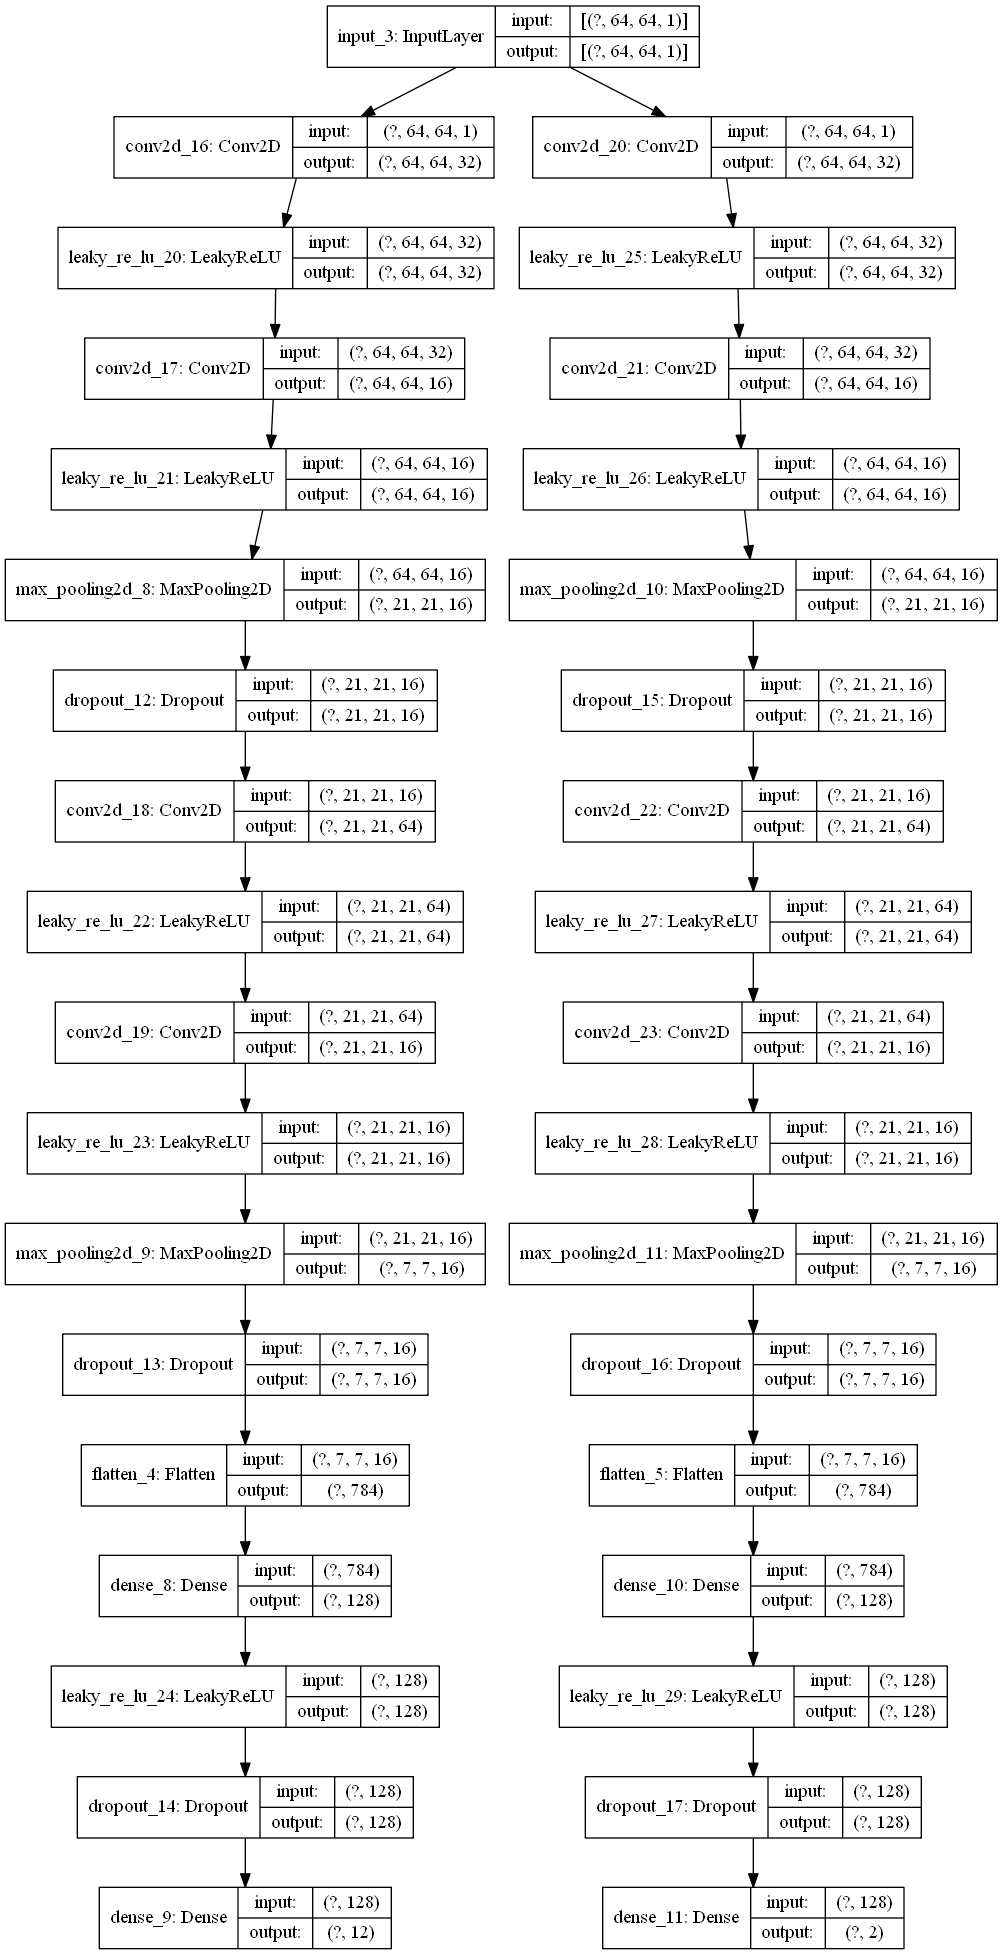

In [21]:
# display model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [108]:
# model evaluation functions
def evaluate_model(dataX, dataY1, dataY2, n_folds=5):
    scores1, scores2, histories = list(), list(), list() # initializing to keep track
    # prep cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows to train/test
        trainX, trainY1, trainY2, testX, testY1, testY2 = dataX[train_ix], dataY1[train_ix], dataY2[train_ix], dataX[test_ix], dataY1[test_ix], dataY2[test_ix]
        # fit the model
        history = model.fit(x=trainX, y={'label1': trainY1, 'label2': trainY2}, epochs=10, batch_size=32)
        # evaluate model
        loss, main_loss, aux_loss, main_acc, aux_acc = model.evaluate(x=testX, y={'label1': testY1, 'label2': testY2}, verbose=0) # returns loss value and eval metric, we're only interested in that second one
        print('> %.3f' % (main_acc * 100.0))
        print('> %.3f' % (aux_acc * 100.0))
        # append scores
        scores1.append(main_acc)
        scores2.append(aux_acc)
        histories.append(history)
    return scores1, scores2, histories

# no change
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

# no change
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
# no change
def run_test_harness():
    # load dataset
    X_train, X_test, y1_train, y1_test, y2_train, y2_test = load_dataset()
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, X_test)
    # evaluate model
    scores, histories = evaluate_model(X_train, y1_train, y2_train)
    # learning curves
    #summarize_diagnostics(histories)
    # summarize estimated performance
    #summarize_performance(scores)

In [109]:
scores1, scores2, histories = evaluate_model(X_train, y1_train, y2_train)

Epoch 1/10
30/30 [==============================] - 10s 321ms/step - loss: 3.1168 - label1_loss: 2.4863 - label2_loss: 0.6306 - label1_accuracy: 0.1097 - label2_accuracy: 0.6753
Epoch 2/10
30/30 [==============================] - 10s 331ms/step - loss: 3.0982 - label1_loss: 2.4779 - label2_loss: 0.6203 - label1_accuracy: 0.1097 - label2_accuracy: 0.7054
Epoch 3/10
30/30 [==============================] - 9s 316ms/step - loss: 3.0841 - label1_loss: 2.4742 - label2_loss: 0.6100 - label1_accuracy: 0.1151 - label2_accuracy: 0.7054
Epoch 4/10
30/30 [==============================] - 10s 323ms/step - loss: 3.0607 - label1_loss: 2.4548 - label2_loss: 0.6059 - label1_accuracy: 0.1398 - label2_accuracy: 0.7054
Epoch 5/10
30/30 [==============================] - 9s 316ms/step - loss: 2.9308 - label1_loss: 2.3228 - label2_loss: 0.6080 - label1_accuracy: 0.2065 - label2_accuracy: 0.7054
Epoch 6/10
30/30 [==============================] - 9s 316ms/step - loss: 2.1141 - label1_loss: 1.5033 - label2_

C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


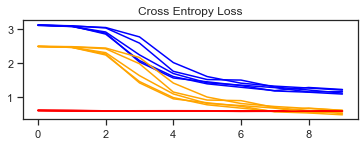

In [94]:
# plot losses
for i in range(len(histories)):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='overall')
    plt.plot(histories[i].history['label1_loss'], color='orange', label='label1')
    plt.plot(histories[i].history['label2_loss'], color='red', label='label2')
plt.show()

In [95]:
scores1

[0.8540772795677185,
 0.8841201663017273,
 0.8712446093559265,
 0.875,
 0.8793103694915771]

In [96]:
scores2

[0.7467811107635498,
 0.733905553817749,
 0.6824034452438354,
 0.7068965435028076,
 0.6982758641242981]

# Tune params of best model so far

**Add regularizers**

In [111]:
# validation split from 10% to 15%
def load_dataset():
    # load arrays
    photos = load(path_data + 'photos_24classes.npy')
    labels = load(path_data + 'labels_24classes.npy')
    
    # split between train/test and reshape
    X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size=0.15, shuffle=False)
    y_train = np.reshape(y_train, (X_train.shape[0],))
    y_test = np.reshape(y_test, (X_test.shape[0],))
    
    # hot encode target variables
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, X_test, y_train, y_test

# no change
def prep_pixels(train, test):
    # convert from integers to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    # return normalized images
    return train_norm, test_norm

# define model  with 20 neurons at last layer
def define_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),input_shape=(64, 64, 1))) #conv layer
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.MaxPooling2D((2,2))) #pooling layer
    model.add(layers.Conv2D(64, (3,3), activation='relu',  padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))              
    model.add(layers.Flatten()) # 16384 vector
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 1 hidden layer
    model.add(layers.Dense(24, activation='softmax')) # output, size 42 = nuber of classes
    # compile model
    opt = optimizers.SGD(lr=0.01, momentum=0.9) # gradient descent with momentum optimizer
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 15 epochs to evaluate
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list() # initializing to keep track
    # prep cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows to train/test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit the model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0) # returns loss value and eval metric, we're only interested in that second one
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# no change
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

# no change
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
# no change
def run_test_harness():
    # load dataset
    X_train, X_test, y_train, y_test = load_dataset()
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, X_test)
    # evaluate model
    scores, histories = evaluate_model(X_train, y_train)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> 80.687
> 84.979
> 86.695
> 82.328
> 84.052


C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\derob\anaconda3\lib\site-packages\ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


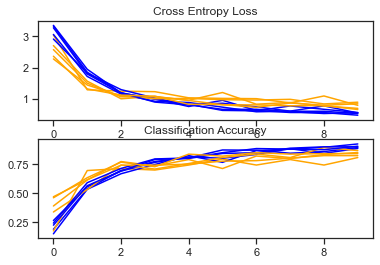

Accuracy: mean=83.748 std=2.082, n=5


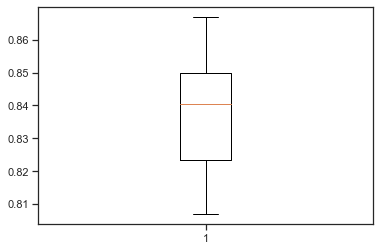

In [112]:
run_test_harness()

In [113]:
# train model on all params
model

In [117]:
# fit model on whole data available - 50 epoch
# load dataset
X_train, X_test, y_train, y_test = load_dataset()
# prepare pixel data
X_train, X_test = prep_pixels(X_train, X_test)
model = define_model()
model.fit(X_train, y_train, epochs=30, batch_size=24)

Epoch 1/30
49/49 [==============================] - 8s 165ms/step - loss: 2.7741 - accuracy: 0.3035
Epoch 2/30
49/49 [==============================] - 8s 169ms/step - loss: 1.3973 - accuracy: 0.6535
Epoch 3/30
49/49 [==============================] - 8s 170ms/step - loss: 1.0483 - accuracy: 0.77044s - - ETA: 1s - loss: 1.0697 - accura - ETA: 1s - loss: 1.0668 - ac
Epoch 4/30
49/49 [==============================] - 8s 171ms/step - loss: 0.8172 - accuracy: 0.8134
Epoch 5/30
49/49 [==============================] - 9s 183ms/step - loss: 0.7563 - accuracy: 0.83750s - loss: 0.7621 - accura
Epoch 6/30
49/49 [==============================] - 8s 165ms/step - loss: 0.6484 - accuracy: 0.8779
Epoch 7/30
49/49 [==============================] - 8s 158ms/step - loss: 0.6395 - accuracy: 0.8710
Epoch 8/30
49/49 [==============================] - 8s 165ms/step - loss: 0.5770 - accuracy: 0.8891
Epoch 9/30
49/49 [==============================] - 8s 164ms/step - loss: 0.4903 - accuracy: 0.9114
Epoch 

In [118]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 72.330


In [119]:
# keeping first model - calling it the end for now!